# Detección de Fugas en Sistemas de Distribución de Agua usando Espectrogramas Logarítmicos

## 1. Importación de Librerías

In [1]:
# Importación de la clase WaveletDenoising
!pip install PyWavelets
import pywt
from denoising import WaveletDenoising

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 32.3 MB/s eta 0:00:00


In [2]:
# Importación de librerías necesarias
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import signal
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
import seaborn as sns
import h5py
from tqdm import tqdm
import random
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report




In [4]:

# Para montar Google Drive
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


## 2. Cargar y Visualizar Datos

Data Directory: /content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched
Sample Rate: 25600 Hz
Classification Mode: five_classes
Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


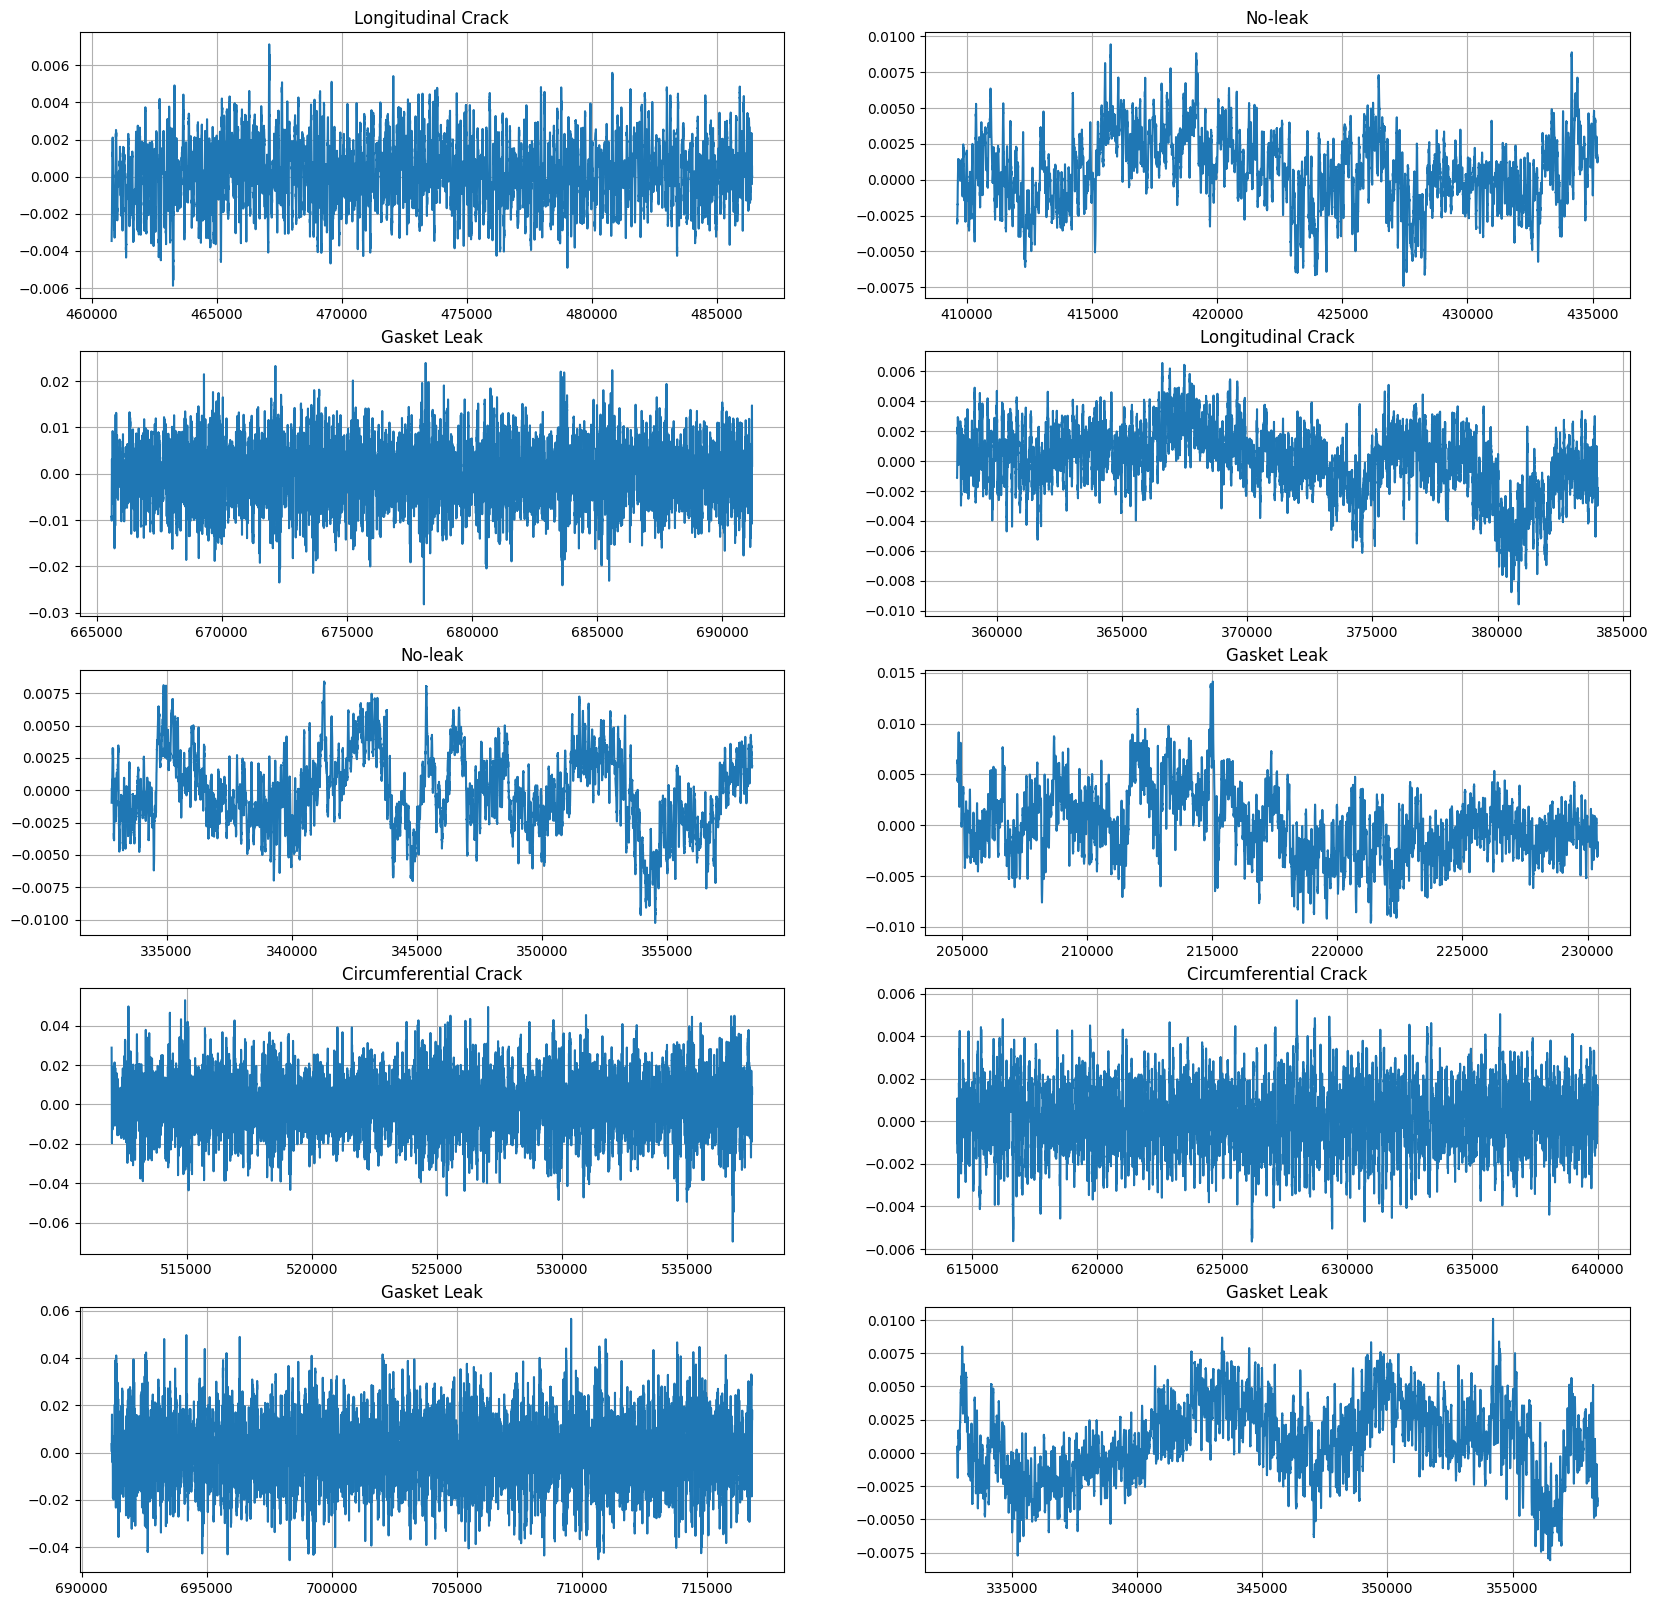

In [7]:
# Cambiando la ruta para acceder a los datos en Google Drive
data_dir = '/content/drive/MyDrive/Tesis/Accelerometer_Dataset/Branched'
original_sr = 25600  # in Hz
signal_sr = 25600  # in Hz
downsample_factor = original_sr//signal_sr

# Modo de clasificación: 'five_classes' o 'binary'
classification_mode = 'five_classes'  # Cambiar según necesidad

# Definir diccionarios de etiquetas según el modo de clasificación
if classification_mode == 'five_classes':
    label_codes_dict = {'Circumferential Crack': 0, 'Gasket Leak': 1, 'Longitudinal Crack': 2, 'No-leak': 3, 'Orifice Leak': 4}
else:  # binary
    label_codes_dict = {'Leak': 0, 'No-leak': 1}

# Esta función elimina el archivo .DS_Store si existe en la ruta definida
def remove_DS_store_file(path):
    # Buscar tanto .DS_Store como .DS_store (diferencias de capitalización)
    for ds_name in ['.DS_Store', '.DS_store']:
        ds_store_file_location = os.path.join(path, ds_name)
        if os.path.isfile(ds_store_file_location):
            os.remove(ds_store_file_location)

def load_accelerometer_data(data_dir, sample_rate, downsample_factor, label_codes, mode='five_classes', fraction_to_include=1):
    """
    Carga datos de acelerómetro con opción para clasificación binaria o multiclase

    Args:
        data_dir: Directorio donde se encuentran los datos
        sample_rate: Tasa de muestreo deseada
        downsample_factor: Factor de submuestreo
        label_codes: Diccionario de códigos de etiquetas
        mode: 'five_classes' o 'binary'
        fraction_to_include: Fracción de frames a incluir

    Returns:
        signals: Lista de señales
        labels: Lista de etiquetas
    """
    # Eliminar .DS_Store si existe en data_dir
    remove_DS_store_file(data_dir)

    signals = []
    labels = []

    # Para el modo binario, necesitamos contabilizar cuántos frames hay por cada tipo de fuga
    leak_counts = {
        'Circumferential Crack': 0,
        'Gasket Leak': 0,
        'Longitudinal Crack': 0,
        'Orifice Leak': 0
    }
    leak_signals = {
        'Circumferential Crack': [],
        'Gasket Leak': [],
        'Longitudinal Crack': [],
        'Orifice Leak': []
    }
    no_leak_signals = []
    no_leak_labels = []

    for label in os.listdir(data_dir):
        label_dir = os.path.join(data_dir, label)

        # Verificar que sea un directorio antes de procesarlo
        if not os.path.isdir(label_dir):
            print(f"Omitiendo {label_dir} porque no es un directorio")
            continue

        # Eliminar .DS_Store si existe
        remove_DS_store_file(label_dir)

        for file in os.listdir(label_dir):
            file_path = os.path.join(label_dir, file)

            # Verificar que sea un archivo
            if not os.path.isfile(file_path):
                continue

            # Cargar el archivo csv
            accelerometer_signal_df = pd.read_csv(file_path, index_col=False)

            # Submuestrear seleccionando cada n-ésima fila
            accelerometer_signal_df = accelerometer_signal_df.iloc[::downsample_factor, :]
            accelerometer_signal_df = accelerometer_signal_df.reset_index(drop=True)

            # Obtener 30 segundos de datos
            accelerometer_signal = accelerometer_signal_df['Value'][0:(sample_rate*30)]

            # Generar un vector con el índice de inicio para cada frame de 1 segundo
            sample_indexes = np.linspace(0,len(accelerometer_signal)-sample_rate,len(accelerometer_signal)//sample_rate)

            # Obtener el número de frames de señal
            signal_frames_number = fraction_to_include*len(sample_indexes)
            signal_frames_counter = 0

            # Generar frames de señal de 1 segundo a partir de la señal original
            for signal_frame in sample_indexes:
                accelerometer_signal_frame = accelerometer_signal[int(signal_frame):int(signal_frame+sample_rate)]
                signal_frames_counter+=1

                if signal_frames_counter > signal_frames_number:
                    break

                if len(accelerometer_signal_frame) != sample_rate:
                    continue

                if mode == 'five_classes':
                    # Guardar directamente para clasificación de 5 clases
                    signals.append(accelerometer_signal_frame)
                    labels.append(label_codes[label])
                else:  # modo binario
                    # Para modo binario, guardamos las señales según su tipo
                    if label == 'No-leak':
                        no_leak_signals.append(accelerometer_signal_frame)
                        no_leak_labels.append(1)  # 1 para No-leak en modo binario
                    else:
                        # Guardar en la categoría correspondiente
                        leak_signals[label].append(accelerometer_signal_frame)
                        leak_counts[label] += 1

    # Si estamos en modo binario, equilibramos el dataset
    if mode == 'binary':
        # Encontrar la cantidad mínima de ejemplos por tipo de fuga
        min_count_per_leak_type = min(leak_counts.values()) if leak_counts else 0

        # Calcular cuántos ejemplos necesitamos de cada tipo para equilibrar con No-leak
        if len(no_leak_signals) > 0 and len(leak_counts) > 0:
            total_leak_samples_needed = len(no_leak_signals)
            samples_per_leak_type = total_leak_samples_needed // len(leak_counts)

            # Asegurar que no tomamos más muestras de las disponibles
            samples_per_leak_type = min(samples_per_leak_type, min_count_per_leak_type)

            # Seleccionar muestras equilibradas de cada tipo de fuga
            balanced_leak_signals = []
            for leak_type in leak_signals:
                if leak_signals[leak_type]:
                    # Tomar una muestra aleatoria del tamaño necesario
                    selected_signals = random.sample(leak_signals[leak_type],
                                                    min(samples_per_leak_type, len(leak_signals[leak_type])))
                    balanced_leak_signals.extend(selected_signals)

            # Crear etiquetas para las señales de fuga (0 para Leak en modo binario)
            balanced_leak_labels = [0] * len(balanced_leak_signals)

            # Combinar todo
            signals = balanced_leak_signals + no_leak_signals
            labels = balanced_leak_labels + no_leak_labels

            print(f"Modo binario: {len(balanced_leak_labels)} muestras de fuga, {len(no_leak_labels)} muestras sin fuga")

    return signals, labels

# Cargar los datos desde Google Drive
signals_lst, labels_lst = load_accelerometer_data(
    data_dir,
    signal_sr,
    downsample_factor,
    label_codes_dict,
    mode= classification_mode,
    fraction_to_include=1
)

signals_dict = {'training': [], 'testing': []}
labels_dict = {'training': [], 'testing': []}

# Generar diccionarios con subconjuntos de entrenamiento y prueba a partir de los datos cargados
signals_dict['training'], signals_dict['testing'], labels_dict['training'], labels_dict['testing'] = train_test_split(
    signals_lst,
    labels_lst,
    test_size=0.2,
    random_state=53
)

# Imprimir información sobre el dataset resultante:
print(f'Data Directory: {data_dir}')
print(f'Sample Rate: {signal_sr} Hz')
print(f'Classification Mode: {classification_mode}')
print(f'Number of signals (training, testing): ({len(signals_dict["training"])}, {len(signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(signals_dict["training"][np.random.randint(0,len(signals_dict["training"]))])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols
random_index = []

for i in range(n):
    plt.subplot(rows, cols, i+1)
    random_index.append(np.random.randint(0, len(signals_dict['training'])))
    plt.plot(signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

## 3. Normalización y Denoising con Wavelet

Denoising testing signals: 100%|██████████| 240/240 [00:00<00:00, 328.94it/s]


Number of signals (training, testing): (960, 240)
Number of labels (training, testing): (960, 240)
Number of samples per signal: 25600


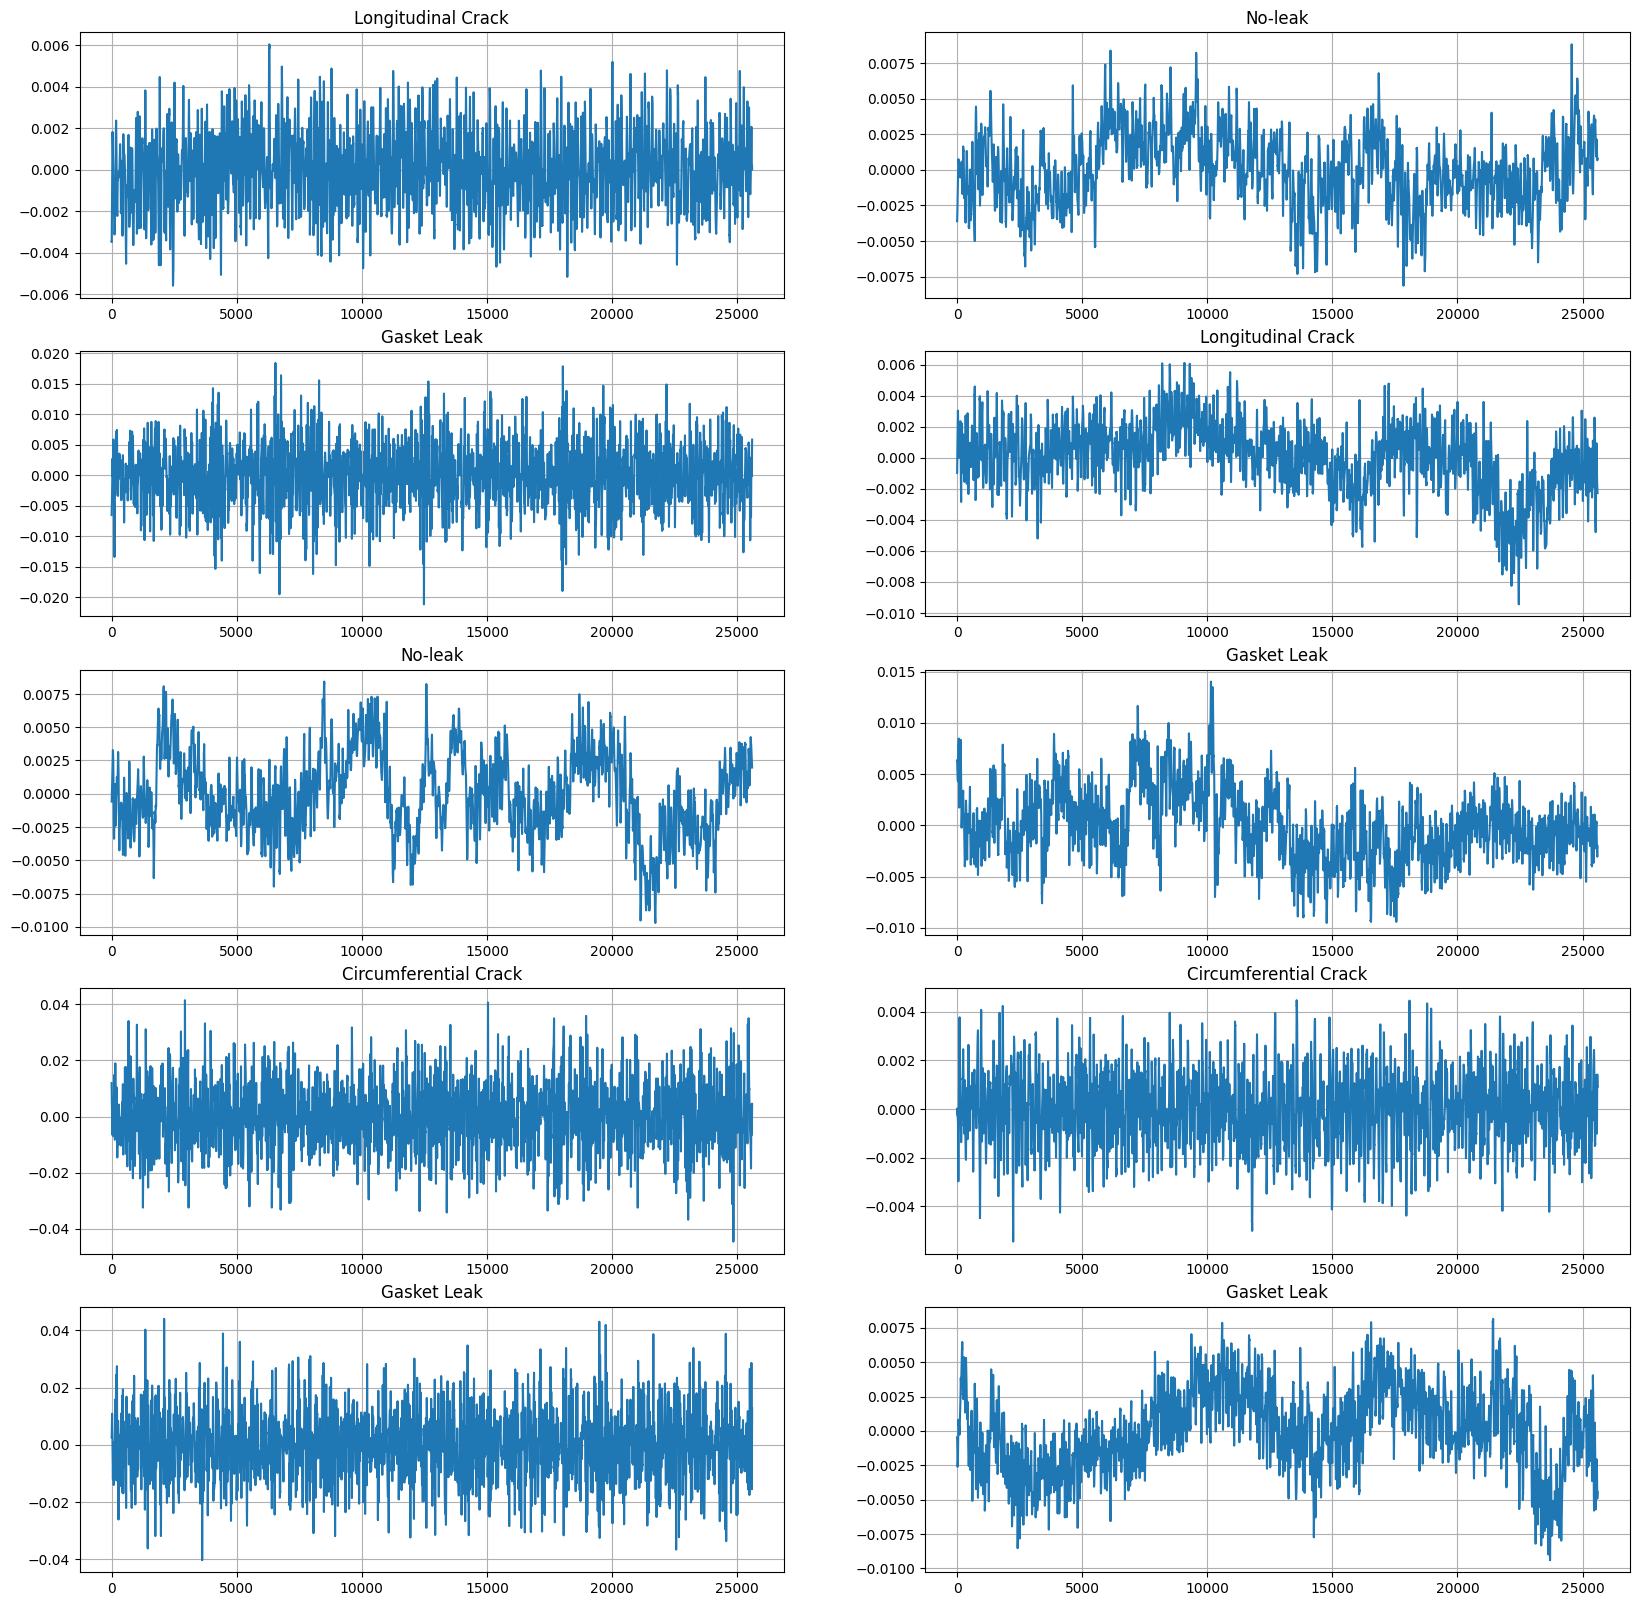

In [8]:
def wavelet_denoise(signals_dict, labels_dict):
    """
    Normaliza y aplica denoising wavelet a las señales

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas de entrenamiento y prueba

    Returns:
        wavelet_denoised_signals: Diccionario con señales procesadas
        labels_dict: Diccionario con etiquetas
    """
    # Crear un objeto de la clase WaveletDenoising
    wd = WaveletDenoising(normalize=True,
                      wavelet='sym3',
                      level=4,
                      thr_mode='soft',
                      method="universal")

    # Crear un nuevo diccionario para almacenar los coeficientes calculados:
    wavelet_denoised_signals = {'training': [], 'testing': []}

    for key, signals_subset in signals_dict.items():
        for signal_element in tqdm(signals_subset, desc=f"Denoising {key} signals"):
            # Denoising de la señal usando el método wavelet denoising
            denoised_signal = wd.fit(signal_element)

            # Almacenar las señales denoised en el nuevo diccionario
            wavelet_denoised_signals[key].append(denoised_signal)

    return wavelet_denoised_signals, labels_dict

# Denoising de las señales en los diccionarios de entrenamiento y prueba
wavelet_denoised_signals_dict, labels_dict = wavelet_denoise(signals_dict=signals_dict, labels_dict=labels_dict)

# Imprimir información sobre el dataset resultante:
print(f'Number of signals (training, testing): ({len(wavelet_denoised_signals_dict["training"])}, {len(wavelet_denoised_signals_dict["testing"])})')
print(f'Number of labels (training, testing): ({len(labels_dict["training"])}, {len(labels_dict["testing"])})')
print(f'Number of samples per signal: {len(wavelet_denoised_signals_dict["training"][0])}')

# Graficar algunas de las señales resultantes
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.plot(wavelet_denoised_signals_dict['training'][random_index[i]])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.title(label_name)
    plt.grid()

 ## 4. Generación de Espectrogramas Logarítmicos mediante STFT

Generating spectrograms for testing: 100%|██████████| 240/240 [00:00<00:00, 751.64it/s]


Number of spectrograms (training, testing): (960, 240)
Spectrogram shape: (257, 101)


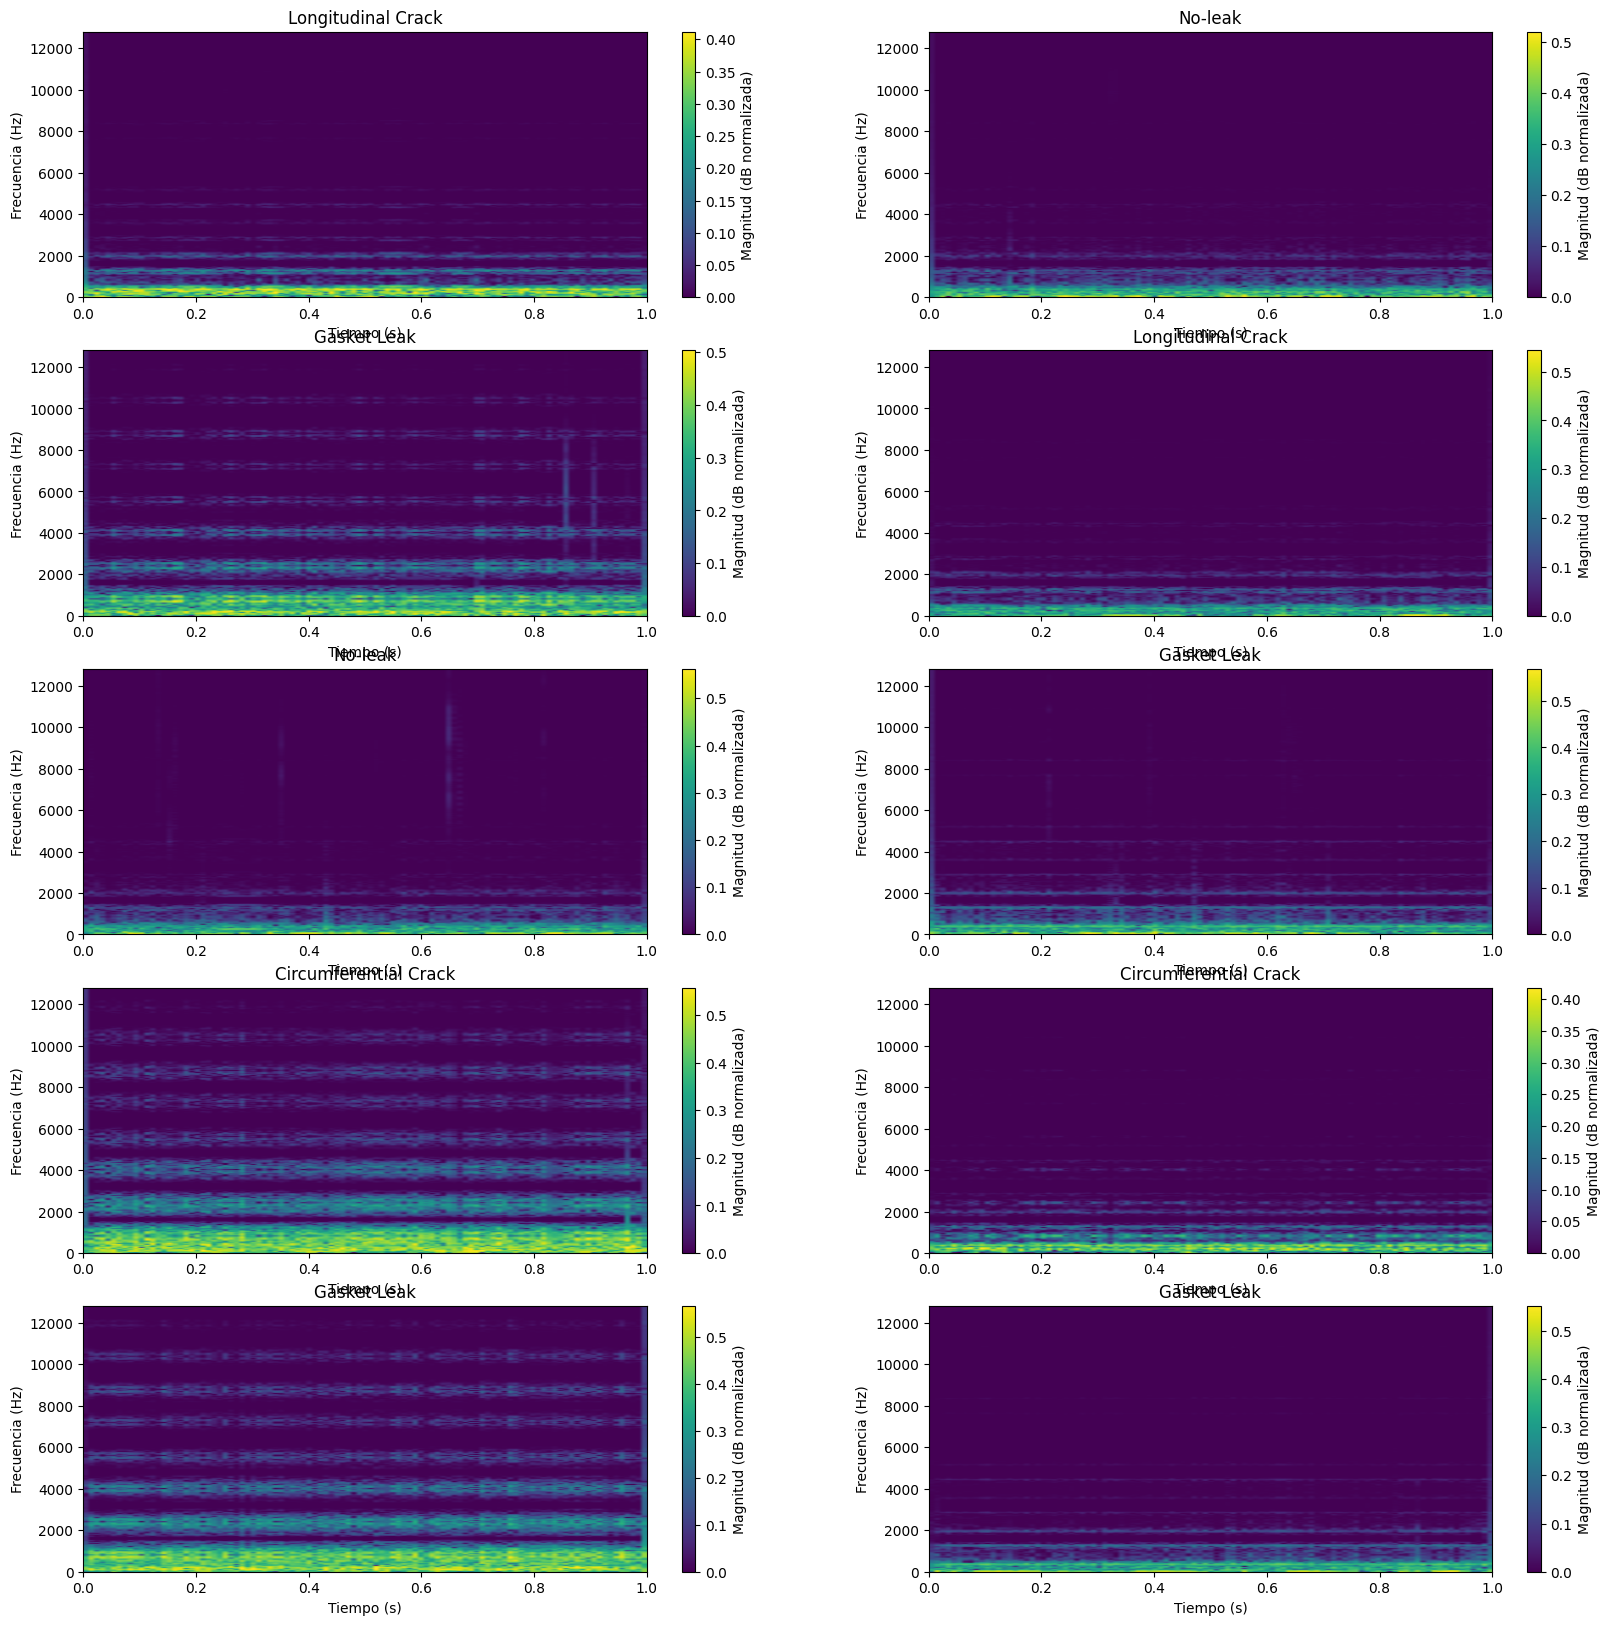

In [9]:
def generate_log_spectrograms(signals_dict, labels_dict, fs=25600):
    """
    Genera espectrogramas logarítmicos usando STFT

    Args:
        signals_dict: Diccionario con señales de entrenamiento y prueba
        labels_dict: Diccionario con etiquetas
        fs: Frecuencia de muestreo en Hz

    Returns:
        spectrograms_dict: Diccionario con espectrogramas
        labels_dict: Diccionario con etiquetas
    """
    # Parámetros para STFT adaptados a nuestra frecuencia de muestreo (25.6kHz vs 8kHz del paper)
    # Frame length: 20ms × 25.6kHz = 512 muestras
    # Frame shift: 10ms × 25.6kHz = 256 muestras
    frame_length = int(0.02 * fs)  # 20 ms
    frame_shift = int(0.01 * fs)  # 10 ms
    nfft = 512  # Tamaño de FFT como se especificó

    # Crear diccionario para almacenar espectrogramas
    spectrograms_dict = {'training': [], 'testing': []}

    # Verificar si es necesario eliminar frames con ruido de alta energía
    apply_denoising = False

    # Umbral para identificar frames con ruido (ajustar según sea necesario)
    mean_threshold = 0.7
    std_threshold = 0.5

    for key, signals_subset in signals_dict.items():
        for i, signal in enumerate(tqdm(signals_subset, desc=f"Generating spectrograms for {key}")):
            # Aplicar STFT
            f, t, Zxx = scipy.signal.stft(
                signal,
                fs=fs,
                window='hann',
                nperseg=frame_length,
                noverlap=frame_length-frame_shift,
                nfft=nfft
            )

            # Calcular espectrograma de potencia (magnitud al cuadrado)
            power_spectrogram = np.abs(Zxx)**2

            if apply_denoising:
                # Identificar frames con ruido de alta energía
                frame_means = np.mean(power_spectrogram, axis=0)
                frame_stds = np.std(power_spectrogram, axis=0)

                # Normalizar para obtener valores relativos
                norm_means = frame_means / np.max(frame_means)
                norm_stds = frame_stds / np.max(frame_stds)

                # Identificar frames ruidosos que superan los umbrales
                noisy_frames = (norm_means > mean_threshold) | (norm_stds > std_threshold)

                # Procesar frames ruidosos
                for j, is_noisy in enumerate(noisy_frames):
                    if is_noisy:
                        # Obtener el espectro del frame actual
                        frame_spectrum = power_spectrogram[:, j]

                        # Reemplazar valores de baja frecuencia (< 300Hz) que podrían contener ruido de baja frecuencia
                        low_freq_bins = int(300 / (fs/2) * (nfft//2))
                        frame_spectrum[:low_freq_bins] = np.mean(frame_spectrum[:low_freq_bins]) * 0.1

                        # Encontrar los picos locales (1-2 picos)
                        # Usamos una ventana de 10 bins para encontrar máximos locales
                        from scipy.signal import find_peaks
                        peaks, _ = find_peaks(frame_spectrum, distance=10)

                        if len(peaks) > 0:
                            # Crear una nueva versión del espectro con solo los picos principales
                            new_spectrum = np.zeros_like(frame_spectrum)

                            # Tomar los 2 picos más grandes si hay suficientes
                            num_peaks_to_keep = min(2, len(peaks))
                            peak_indices = peaks[np.argsort(frame_spectrum[peaks])[-num_peaks_to_keep:]]

                            # Mantener valor solo en los picos y sus alrededores
                            for peak_idx in peak_indices:
                                window_size = 5  # Bins a mantener alrededor del pico
                                start_idx = max(0, peak_idx - window_size)
                                end_idx = min(len(frame_spectrum), peak_idx + window_size + 1)
                                new_spectrum[start_idx:end_idx] = frame_spectrum[start_idx:end_idx]

                            # Reemplazar el frame original
                            power_spectrogram[:, j] = new_spectrum

            # Convertir a escala logarítmica (dB), agregando un pequeño valor para evitar log(0)
            eps = 1e-10
            log_spectrogram = 10 * np.log10(power_spectrogram + eps)

            # Normalizar a un rango adecuado
            log_spectrogram = np.clip(log_spectrogram, -100, 0)  # Limitar valores mínimos
            log_spectrogram = (log_spectrogram + 100) / 100  # Normalizar a [0, 1]

            # Transponer para tener tiempo en el eje horizontal y frecuencia en el vertical
            # También invertir el eje de frecuencia para que las frecuencias bajas estén abajo
            #log_spectrogram = log_spectrogram.T

            # Almacenar en el diccionario
            spectrograms_dict[key].append(log_spectrogram)

    return spectrograms_dict, labels_dict

# Generar espectrogramas logarítmicos
spectrograms_dict, labels_dict = generate_log_spectrograms(
    wavelet_denoised_signals_dict,
    labels_dict,
    fs=signal_sr
)

# Imprimir información sobre los espectrogramas
print(f'Number of spectrograms (training, testing): ({len(spectrograms_dict["training"])}, {len(spectrograms_dict["testing"])})')
print(f'Spectrogram shape: {spectrograms_dict["training"][0].shape}')

# Visualizar algunos espectrogramas
plt.figure(figsize=(20, 20))
rows = 5
cols = 2
n = rows * cols

for i in range(n):
    plt.subplot(rows, cols, i+1)
    plt.imshow(spectrograms_dict['training'][random_index[i]], aspect='auto', origin='lower',
              extent=[0, 1, 0, signal_sr/2])

    # Obtener el nombre de la etiqueta según el modo de clasificación
    if classification_mode == 'five_classes':
        label_name = list(label_codes_dict.keys())[list(label_codes_dict.values()).index(labels_dict['training'][random_index[i]])]
    else:
        label_name = 'Leak' if labels_dict['training'][random_index[i]] == 0 else 'No-leak'

    plt.colorbar(label='Magnitud (dB normalizada)')
    plt.title(label_name)
    plt.xlabel('Tiempo (s)')
    plt.ylabel('Frecuencia (Hz)')

## 5. Preparación de Datos para el Modelo CNN

In [10]:
def prepare_data_for_model(spectrograms_dict, labels_dict, classification_mode):
    """
    Prepara los datos para el modelo CNN

    Args:
        spectrograms_dict: Diccionario con espectrogramas
        labels_dict: Diccionario con etiquetas
        classification_mode: Modo de clasificación ('five_classes' o 'binary')

    Returns:
        x_train, y_train, x_test, y_test: Datos preparados para entrenamiento
        num_classes: Número de clases
    """
    # Convertir a arrays numpy
    x_train = np.array(spectrograms_dict['training'])
    y_train = np.array(labels_dict['training'])
    x_test = np.array(spectrograms_dict['testing'])
    y_test = np.array(labels_dict['testing'])

    # Asegurar que los espectrogramas tengan valores normalizados
    x_train = np.clip(x_train, 0, 1)
    x_test = np.clip(x_test, 0, 1)

    # Expandir dimensión para canal (necesario para CNN)
    x_train = np.expand_dims(x_train, axis=-1)
    x_test = np.expand_dims(x_test, axis=-1)

    # Determinar número de clases según el modo
    if classification_mode == 'five_classes':
        num_classes = 5
    else:  # binary
        num_classes = 2

    # One-hot encoding de las etiquetas
    y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes)
    y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes)

    return x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, num_classes

# Preparar los datos para el modelo
x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot, num_classes = prepare_data_for_model(
    spectrograms_dict,
    labels_dict,
    classification_mode
)

# Imprimir información sobre los datos preparados
print(f'x_train shape: {x_train.shape}')
print(f'y_train_onehot shape: {y_train_onehot.shape}')
print(f'x_test shape: {x_test.shape}')
print(f'y_test_onehot shape: {y_test_onehot.shape}')
print(f'Number of classes: {num_classes}')

# Guardar en formato HDF5
def save_dataset_to_h5(x_train, y_train, y_train_onehot, x_test, y_test, y_test_onehot,
                       classification_mode, num_classes, label_codes_dict,
                       file_path=None):
    """
    Guarda el dataset en formato HDF5
    """
    if file_path is None:
        file_path = f'/content/drive/MyDrive/Tesis/Accelerometer_Dataset/log_spectrogram_dataset_{classification_mode}.h5'

    print(f"Guardando dataset en {file_path}...")
    with h5py.File(file_path, 'w') as hf:
        # Crear grupos para training y testing
        train_group = hf.create_group('train')
        test_group = hf.create_group('test')

        # Guardar espectrogramas y etiquetas procesados
        train_group.create_dataset('spectrograms', data=x_train)
        train_group.create_dataset('labels', data=y_train)
        train_group.create_dataset('labels_onehot', data=y_train_onehot)

        test_group.create_dataset('spectrograms', data=x_test)
        test_group.create_dataset('labels', data=y_test)
        test_group.create_dataset('labels_onehot', data=y_test_onehot)

        # Guardar metadatos
        metadata = hf.create_group('metadata')
        metadata.create_dataset('num_classes', data=num_classes)
        metadata.create_dataset('shape', data=np.array(x_train.shape[1:]))
        metadata.attrs['classification_mode'] = classification_mode

        # Guardar diccionario de etiquetas
        import json
        if classification_mode == 'five_classes':
            label_codes_json = json.dumps({k: int(v) for k, v in label_codes_dict.items()})
        else:  # binary
            label_codes_json = json.dumps({k: int(v) for k, v in {'Leak': 0, 'No-leak': 1}.items()})
        metadata.attrs['label_codes_dict'] = label_codes_json

    print(f"Dataset procesado y guardado en {file_path}")
    print(f"Datos de entrenamiento: {len(x_train)} muestras")
    print(f"Datos de prueba: {len(x_test)} muestras")

    # Verificar la existencia del archivo guardado
    if os.path.exists(file_path):
        print(f"Archivo guardado correctamente. Tamaño: {os.path.getsize(file_path) / (1024*1024):.2f} MB")
    else:
        print("Error: No se pudo guardar el archivo")

# Guardar el dataset
save_dataset_to_h5(
    x_train, y_train, y_train_onehot,
    x_test, y_test, y_test_onehot,
    classification_mode, num_classes, label_codes_dict
)

x_train shape: (960, 257, 101, 1)
y_train_onehot shape: (960, 5)
x_test shape: (240, 257, 101, 1)
y_test_onehot shape: (240, 5)
Number of classes: 5
Guardando dataset en /content/drive/MyDrive/Tesis/Accelerometer_Dataset/log_spectrogram_dataset_five_classes.h5...
Dataset procesado y guardado en /content/drive/MyDrive/Tesis/Accelerometer_Dataset/log_spectrogram_dataset_five_classes.h5
Datos de entrenamiento: 960 muestras
Datos de prueba: 240 muestras
Archivo guardado correctamente. Tamaño: 237.71 MB


## 6. Implementación y Entrenamiento del Modelo Log PS-ResNet18

In [12]:
def residual_block(x, filters, kernel_size=3, stride=1, conv_shortcut=False):
    """
    Bloque residual básico para ResNet
    """
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same')(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same')(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

def build_log_ps_resnet18(input_shape, is_binary=True):
    """
    Construye el modelo Log PS-ResNet18

    Args:
        input_shape: Forma de entrada (alto, ancho, canales)
        is_binary: Si True, construye para clasificación binaria

    Returns:
        model: Modelo compilado
    """
    inputs = layers.Input(shape=input_shape)

    # Bloque inicial
    x = layers.Conv2D(64, 7, strides=2, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)

    # ResNet bloques
    # Etapa 1
    x = residual_block(x, 64)
    x = residual_block(x, 64)

    # Etapa 2
    x = residual_block(x, 128, stride=2, conv_shortcut=True)
    x = residual_block(x, 128)

    # Etapa 3
    x = residual_block(x, 256, stride=2, conv_shortcut=True)
    x = residual_block(x, 256)

    # Etapa 4
    x = residual_block(x, 512, stride=2, conv_shortcut=True)
    x = residual_block(x, 512)

    # Capa de clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu')(x)
    x = layers.Dropout(0.5)(x)

    # Configuración de salida según tipo de clasificación
    if is_binary:
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:  # multiclase
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'

    model = models.Model(inputs, outputs, name="log_ps_resnet18")

    # Compilar modelo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.001),
        loss=loss,
        metrics=['accuracy']
    )

    return model

# Crear conjuntos de entrenamiento y validación correctamente divididos
# En lugar de usar validation_split, hacemos una división estratificada
from sklearn.model_selection import train_test_split

x_train_final, x_val, y_train_final, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    stratify=y_train,  # Para mantener la proporción de clases
    random_state=42
)

# Construir el modelo (para clasificación binaria)
input_shape = x_train.shape[1:]
model = build_log_ps_resnet18(input_shape, is_binary=True)

# Mostrar resumen del modelo
model.summary()

# Callbacks para entrenamiento
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f'/content/drive/MyDrive/Tesis/Models/log_ps_resnet18_binary.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Entrenar el modelo
batch_size = 32
epochs = 50

# Para clasificación binaria no necesitamos one-hot encoding
history = model.fit(
    x_train_final,
    y_train_final,  # Para binary_crossentropy usamos las etiquetas directamente
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),  # Usamos conjunto de validación explícito
    callbacks=callbacks,
    verbose=1
)

# Evaluar el modelo en conjunto de prueba
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy:.4f}')

# Visualizar resultados del entrenamiento
plt.figure(figsize=(12, 4))

# Gráfico de pérdida
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Gráfico de precisión
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

# Calcular matriz de confusión y métricas de rendimiento
# Para clasificación binaria, necesitamos definir un umbral para las predicciones
y_pred_prob = model.predict(x_test)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Umbral 0.5 para clasificación binaria
cm = confusion_matrix(y_test, y_pred)

# Visualizar matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Leak', 'No-leak'],
            yticklabels=['Leak', 'No-leak'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Imprimir reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=['Leak', 'No-leak']))

# Calcular y mostrar curva ROC
from sklearn.metrics import roc_curve, auc
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

# Guardar el modelo entrenado
model.save('/content/drive/MyDrive/Tesis/Models/log_ps_resnet18_binary_final.h5')
print("Modelo guardado correctamente")

Model: "log_ps_resnet18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 257, 101, 1)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 129, 51, 64)    │          3,200 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 129, 51, 64)    │            256 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu (ReLU)              │ (None, 129, 51, 64)    │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 65, 26, 64)     │              0 │ re_lu[0][0]            │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 65, 26, 64)     │         36,928 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 65, 26, 64)     │            256 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_1 (ReLU)            │ (None, 65, 26, 64)     │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 65, 26, 64)     │         36,928 │ re_lu_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 65, 26, 64)     │            256 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 65, 26, 64)     │              0 │ max_pooling2d[0][0],   │
│                           │                        │                │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_2 (ReLU)            │ (None, 65, 26, 64)     │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 65, 26, 64)     │         36,928 │ re_lu_2[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 65, 26, 64)     │            256 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_3 (ReLU)            │ (None, 65, 26, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 65, 26, 64)     │         36,928 │ re_lu_3[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4

 Total params: 11,447,809 (43.67 MB)

 Trainable params: 11,438,209 (43.63 MB)

 Non-trainable params: 9,600 (37.50 KB)

Epoch 1/50


KeyboardInterrupt: 

# !TENGO UN OVERFITTING SERIO!

In [13]:
def apply_spectrogram_augmentation(spectrograms, labels):
    """
    Aplica aumentación de datos a espectrogramas.
    """
    augmented_spectrograms = []
    augmented_labels = []

    for i, spectrogram in enumerate(spectrograms):
        # Original
        augmented_spectrograms.append(spectrogram)
        augmented_labels.append(labels[i])

        # Técnica 1: Desplazamiento de frecuencia (simula variaciones en frecuencia)
        freq_shift = np.roll(spectrogram, np.random.randint(-5, 5), axis=0)
        augmented_spectrograms.append(freq_shift)
        augmented_labels.append(labels[i])

        # Técnica 2: Desplazamiento de tiempo (simula grabaciones en diferente momento)
        time_shift = np.roll(spectrogram, np.random.randint(-10, 10), axis=1)
        augmented_spectrograms.append(time_shift)
        augmented_labels.append(labels[i])

        # Técnica 3: Agregar ruido Gaussiano (simula ruido ambiental)
        noise = np.random.normal(0, 0.05, spectrogram.shape)
        noisy_spec = spectrogram + noise
        noisy_spec = np.clip(noisy_spec, 0, 1)  # Mantener en rango [0,1]
        augmented_spectrograms.append(noisy_spec)
        augmented_labels.append(labels[i])

        # Técnica 4: SpecAugment (mascara regiones del espectrograma)
        spec_aug = spectrogram.copy()
        # Máscara en frecuencia
        f_mask_size = np.random.randint(1, 10)
        f_start = np.random.randint(0, spectrogram.shape[0] - f_mask_size)
        spec_aug[f_start:f_start+f_mask_size, :] = 0
        # Máscara en tiempo
        t_mask_size = np.random.randint(1, 20)
        t_start = np.random.randint(0, spectrogram.shape[1] - t_mask_size)
        spec_aug[:, t_start:t_start+t_mask_size] = 0
        augmented_spectrograms.append(spec_aug)
        augmented_labels.append(labels[i])

    return np.array(augmented_spectrograms), np.array(augmented_labels)

# Aplicar aumentación de datos solo al conjunto de entrenamiento
augmented_x_train, augmented_y_train = apply_spectrogram_augmentation(x_train_final, y_train_final)
print(f"Tamaño original: {len(x_train_final)}, Tamaño aumentado: {len(augmented_x_train)}")

Tamaño original: 768, Tamaño aumentado: 3840


In [17]:
def build_log_ps_resnet18_with_regularization(input_shape, is_binary=False):
    """
    Construye el modelo con regularización aumentada
    """
    inputs = layers.Input(shape=input_shape)

    # Regularizador L2
    reg = keras.regularizers.l2(0.001)

    # Bloque inicial con regularización
    x = layers.Conv2D(64, 7, strides=2, padding='same', kernel_regularizer=reg)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.MaxPooling2D(3, strides=2, padding='same')(x)
    x = layers.Dropout(0.2)(x)  # Dropout después del primer bloque

    # ResNet bloques (con función modificada que incluye regularización)
    x = residual_block_with_reg(x, 64, reg=reg)
    x = residual_block_with_reg(x, 64, reg=reg)
    x = layers.Dropout(0.3)(x)

    x = residual_block_with_reg(x, 128, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 128, reg=reg)
    x = layers.Dropout(0.3)(x)

    x = residual_block_with_reg(x, 256, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 256, reg=reg)
    x = layers.Dropout(0.4)(x)

    x = residual_block_with_reg(x, 512, stride=2, conv_shortcut=True, reg=reg)
    x = residual_block_with_reg(x, 512, reg=reg)

    # Capa de clasificación
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(512, activation='relu', kernel_regularizer=reg)(x)
    x = layers.Dropout(0.5)(x)  # Aumentar dropout aquí

    if is_binary:
        outputs = layers.Dense(1, activation='sigmoid')(x)
        loss = 'binary_crossentropy'
    else:
        outputs = layers.Dense(num_classes, activation='softmax')(x)
        loss = 'categorical_crossentropy'

    model = models.Model(inputs, outputs, name="log_ps_resnet18_regularized")

    # Compilar modelo con learning rate más bajo
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=0.0005),  # Reducir learning rate
        loss=loss,
        metrics=['accuracy']
    )

    return model

def residual_block_with_reg(x, filters, kernel_size=3, stride=1, conv_shortcut=False, reg=None):
    """
    Bloque residual con regularización
    """
    shortcut = x

    if conv_shortcut:
        shortcut = layers.Conv2D(filters, 1, strides=stride, padding='same', kernel_regularizer=reg)(shortcut)
        shortcut = layers.BatchNormalization()(shortcut)

    x = layers.Conv2D(filters, kernel_size, strides=stride, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size, padding='same', kernel_regularizer=reg)(x)
    x = layers.BatchNormalization()(x)

    x = layers.add([shortcut, x])
    x = layers.ReLU()(x)

    return x

In [20]:
# Crear modelo regularizado
model_reg = build_log_ps_resnet18_with_regularization(input_shape, is_binary=False)

# Callbacks mejorados
callbacks = [
    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=1e-7
    ),
    keras.callbacks.ModelCheckpoint(
        filepath=f'/content/drive/MyDrive/Tesis/Models/log_ps_resnet18_binary_reg.h5',
        monitor='val_accuracy',
        save_best_only=True
    )
]

# Solución: Usar el LearningRateScheduler estándar de Keras en lugar de una implementación personalizada
def warmup_schedule(epoch, lr):
    warmup_epochs = 5
    init_lr = 1e-6
    target_lr = 0.0005

    if epoch < warmup_epochs:
        return init_lr + (target_lr - init_lr) * epoch / warmup_epochs
    return lr

# Agregar el scheduler a los callbacks
callbacks.append(tf.keras.callbacks.LearningRateScheduler(warmup_schedule))

# Entrenamiento
batch_size = 16  # Batch size más pequeño
epochs = 80  # Más épocas

# One-hot encoding de las etiquetas para el conjunto de entrenamiento aumentado
augmented_y_train_onehot = tf.keras.utils.to_categorical(augmented_y_train, num_classes)

# One-hot encoding de las etiquetas para el conjunto de validación
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes)

history = model_reg.fit(
    augmented_x_train,  # Usar datos aumentados
    augmented_y_train_onehot,  # Usar etiquetas one-hot encoded
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val_onehot),  # Usar etiquetas one-hot encoded para validación
    callbacks=callbacks,
    verbose=1
)

Epoch 1/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.1808 - loss: 6.6720

240/240 ━━━━━━━━━━━━━━━━━━━━ 89s 76ms/step - accuracy: 0.1809 - loss: 6.6715 - val_accuracy: 0.2083 - val_loss: 6.2728 - learning_rate: 1.0000e-06
Epoch 2/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 51ms/step - accuracy: 0.2149 - loss: 6.3709 - val_accuracy: 0.2083 - val_loss: 6.3685 - learning_rate: 1.0080e-04
Epoch 3/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.2971 - loss: 5.8677 - val_accuracy: 0.2083 - val_loss: 6.7163 - learning_rate: 2.0060e-04
Epoch 4/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.4421 - loss: 5.2108

240/240 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.4424 - loss: 5.2093 - val_accuracy: 0.3594 - val_loss: 5.3689 - learning_rate: 3.0040e-04
Epoch 5/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.5169 - loss: 4.4797

240/240 ━━━━━━━━━━━━━━━━━━━━ 14s 60ms/step - accuracy: 0.5171 - loss: 4.4781 - val_accuracy: 0.4531 - val_loss: 5.3515 - learning_rate: 4.0020e-04
Epoch 6/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.5949 - loss: 3.7458

240/240 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.5949 - loss: 3.7452 - val_accuracy: 0.4948 - val_loss: 3.7747 - learning_rate: 4.0020e-04
Epoch 7/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.6639 - loss: 3.0925

240/240 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.6640 - loss: 3.0914 - val_accuracy: 0.5781 - val_loss: 3.1405 - learning_rate: 4.0020e-04
Epoch 8/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7144 - loss: 2.5810

240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.7145 - loss: 2.5800 - val_accuracy: 0.7240 - val_loss: 2.2896 - learning_rate: 4.0020e-04
Epoch 9/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.7363 - loss: 2.2095

240/240 ━━━━━━━━━━━━━━━━━━━━ 13s 54ms/step - accuracy: 0.7364 - loss: 2.2089 - val_accuracy: 0.8125 - val_loss: 1.9107 - learning_rate: 4.0020e-04
Epoch 10/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8028 - loss: 1.8021 - val_accuracy: 0.7500 - val_loss: 2.6672 - learning_rate: 4.0020e-04
Epoch 11/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8110 - loss: 1.6053 - val_accuracy: 0.7969 - val_loss: 1.7366 - learning_rate: 4.0020e-04
Epoch 12/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8283 - loss: 1.4128 - val_accuracy: 0.6250 - val_loss: 2.5704 - learning_rate: 4.0020e-04
Epoch 13/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8589 - loss: 1.2546

240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8589 - loss: 1.2544 - val_accuracy: 0.8802 - val_loss: 1.2706 - learning_rate: 4.0020e-04
Epoch 14/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 19s 50ms/step - accuracy: 0.8790 - loss: 1.0974 - val_accuracy: 0.8229 - val_loss: 1.3654 - learning_rate: 4.0020e-04
Epoch 15/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.8786 - loss: 1.0169 - val_accuracy: 0.8229 - val_loss: 1.3233 - learning_rate: 4.0020e-04
Epoch 16/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.8854 - loss: 0.9513

240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 58ms/step - accuracy: 0.8854 - loss: 0.9513 - val_accuracy: 0.8906 - val_loss: 0.9113 - learning_rate: 4.0020e-04
Epoch 17/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8994 - loss: 0.8885 - val_accuracy: 0.7448 - val_loss: 1.5151 - learning_rate: 4.0020e-04
Epoch 18/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.8965 - loss: 0.8449 - val_accuracy: 0.8802 - val_loss: 0.8866 - learning_rate: 4.0020e-04
Epoch 19/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.8941 - loss: 0.8251 - val_accuracy: 0.8490 - val_loss: 0.8672 - learning_rate: 4.0020e-04
Epoch 20/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9071 - loss: 0.7507 - val_accuracy: 0.7969 - val_loss: 1.2474 - learning_rate: 4.0020e-04
Epoch 21/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9130 - loss: 0.7204 - val_accuracy: 0.8646 - val_loss: 0.9375 - learning_rate: 4.0020e-04
Epoch 22/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - a

240/240 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step - accuracy: 0.9106 - loss: 0.6861 - val_accuracy: 0.9219 - val_loss: 0.6687 - learning_rate: 4.0020e-04
Epoch 24/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 50ms/step - accuracy: 0.9192 - loss: 0.6500 - val_accuracy: 0.9167 - val_loss: 0.7249 - learning_rate: 4.0020e-04
Epoch 25/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9260 - loss: 0.6096 - val_accuracy: 0.7500 - val_loss: 1.4129 - learning_rate: 4.0020e-04
Epoch 26/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.9190 - loss: 0.6376 - val_accuracy: 0.9062 - val_loss: 0.7217 - learning_rate: 4.0020e-04
Epoch 27/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9366 - loss: 0.5960 - val_accuracy: 0.7656 - val_loss: 1.3355 - learning_rate: 4.0020e-04
Epoch 28/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9205 - loss: 0.6280 - val_accuracy: 0.8802 - val_loss: 0.7168 - learning_rate: 8.0040e-05
Epoch 29/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - ac

240/240 ━━━━━━━━━━━━━━━━━━━━ 14s 58ms/step - accuracy: 0.9645 - loss: 0.4641 - val_accuracy: 0.9479 - val_loss: 0.5793 - learning_rate: 8.0040e-05
Epoch 30/80
239/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9773 - loss: 0.4139

240/240 ━━━━━━━━━━━━━━━━━━━━ 21s 60ms/step - accuracy: 0.9773 - loss: 0.4137 - val_accuracy: 0.9688 - val_loss: 0.5133 - learning_rate: 8.0040e-05
Epoch 31/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9697 - loss: 0.4098 - val_accuracy: 0.9688 - val_loss: 0.4649 - learning_rate: 8.0040e-05
Epoch 32/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step - accuracy: 0.9769 - loss: 0.3677

240/240 ━━━━━━━━━━━━━━━━━━━━ 22s 59ms/step - accuracy: 0.9769 - loss: 0.3676 - val_accuracy: 0.9792 - val_loss: 0.4334 - learning_rate: 8.0040e-05
Epoch 33/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.9792 - loss: 0.3502 - val_accuracy: 0.9688 - val_loss: 0.4709 - learning_rate: 8.0040e-05
Epoch 34/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9803 - loss: 0.3374 - val_accuracy: 0.9688 - val_loss: 0.4528 - learning_rate: 8.0040e-05
Epoch 35/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9807 - loss: 0.3407 - val_accuracy: 0.9583 - val_loss: 0.4893 - learning_rate: 8.0040e-05
Epoch 36/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9819 - loss: 0.3230 - val_accuracy: 0.9688 - val_loss: 0.4732 - learning_rate: 8.0040e-05
Epoch 37/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 20s 49ms/step - accuracy: 0.9805 - loss: 0.3104 - val_accuracy: 0.9531 - val_loss: 0.4853 - learning_rate: 1.6008e-05
Epoch 38/80
240/240 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - a

## Evaluando el modelo

Modelo cargado desde: /content/drive/MyDrive/Tesis/Models/log_ps_resnet18_binary_reg.h5

== Resultados de la Evaluación ==
Precisión en el conjunto de prueba: 0.9750
Pérdida en el conjunto de prueba: 0.3944

== Resultados de la Evaluación ==
Precisión en el conjunto de prueba: 0.9750
Pérdida en el conjunto de prueba: 0.3944


8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step


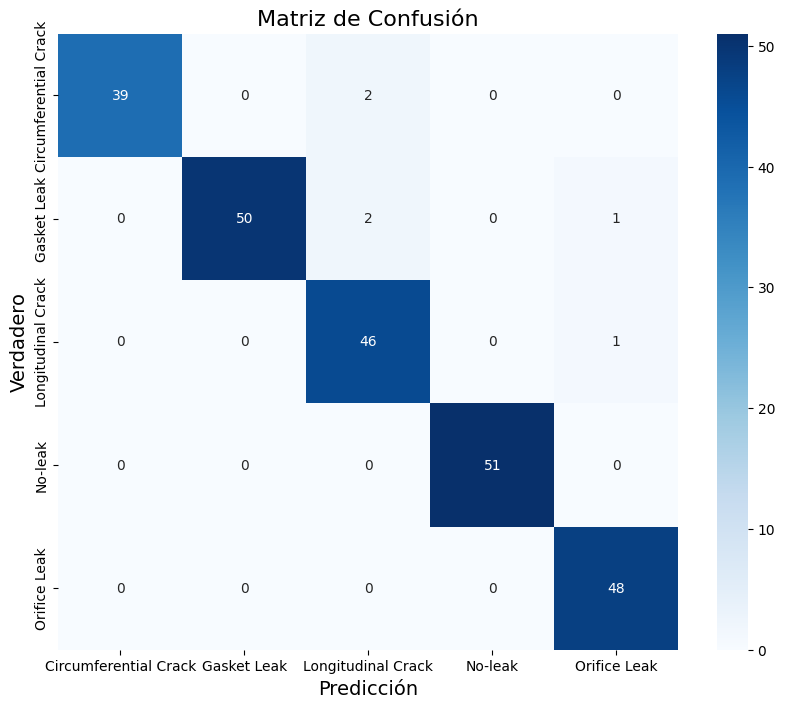


== Informe de Clasificación ==
                       precision    recall  f1-score   support

Circumferential Crack       1.00      0.95      0.97        41
          Gasket Leak       1.00      0.94      0.97        53
   Longitudinal Crack       0.92      0.98      0.95        47
              No-leak       1.00      1.00      1.00        51
         Orifice Leak       0.96      1.00      0.98        48

             accuracy                           0.97       240
            macro avg       0.98      0.97      0.97       240
         weighted avg       0.98      0.97      0.98       240



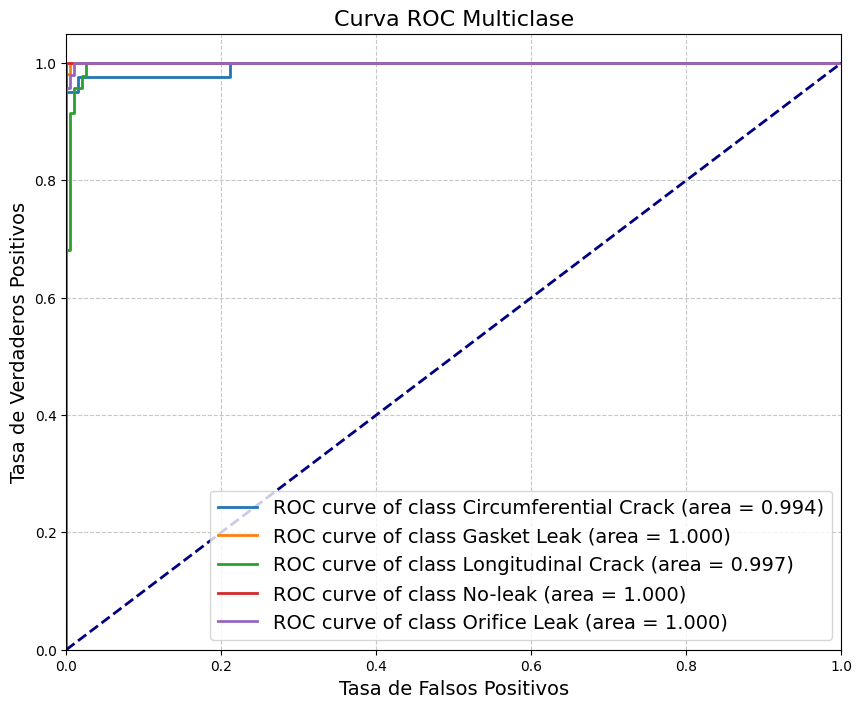

In [26]:
## Evaluación del modelo Log PS-ResNet18 regularizado

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_curve, average_precision_score
import tensorflow as tf
from tensorflow import keras
import h5py

# Cargar el mejor modelo guardado
model_path = '/content/drive/MyDrive/Tesis/Models/log_ps_resnet18_binary_reg.h5'
best_model = keras.models.load_model(model_path)
print(f"Modelo cargado desde: {model_path}")

# Evaluación básica
# Convert y_test to one-hot encoding before evaluation
#y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=5) # Assuming 5 classes
# Update num_classes to 5
y_test_onehot = tf.keras.utils.to_categorical(y_test, num_classes=5) # Assuming 5 classes


test_loss, test_accuracy = best_model.evaluate(x_test, y_test_onehot, verbose=0)
print(f"\n== Resultados de la Evaluación ==")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")
print(f"\n== Resultados de la Evaluación ==")
print(f"Precisión en el conjunto de prueba: {test_accuracy:.4f}")
print(f"Pérdida en el conjunto de prueba: {test_loss:.4f}")

# Obtener predicciones
y_pred_prob = best_model.predict(x_test)
y_pred = np.argmax(y_pred_prob, axis=1)  # Obtener la clase predicha


# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
# Update class names to match 5 classes
class_names = ['Circumferential Crack', 'Gasket Leak', 'Longitudinal Crack', 'No-leak', 'Orifice Leak']
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, # Using the 5 class names
            yticklabels=class_names) # Using the 5 class names
plt.title('Matriz de Confusión', fontsize=16)
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Verdadero', fontsize=14)
plt.show()

# Calcular métricas detalladas
print("\n== Informe de Clasificación ==")
# Update class_names to reflect 5 classes
class_names = ['Circumferential Crack', 'Gasket Leak', 'Longitudinal Crack', 'No-leak', 'Orifice Leak']
print(classification_report(y_test, y_pred, target_names=class_names))

# Calcular y mostrar curva ROC
# Update roc_curve for multi-class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes): # num_classes should be 5
    fpr[i], tpr[i], _ = roc_curve(y_test_onehot[:, i], y_pred_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure(figsize=(10, 8))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], lw=2,
             label=f'ROC curve of class {class_names[i]} (area = {roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos', fontsize=14)
plt.ylabel('Tasa de Verdaderos Positivos', fontsize=14)
plt.title('Curva ROC Multiclase', fontsize=16)
plt.legend(loc="lower right", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()

